In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt


### Read the image files

We first read the image we want to align and the corresponding reference (template) image 

In [2]:
# Read the image files. 
img1_color= cv2.imread('images/align.png') # Image to be aligned. 
img2_color = cv2.imread('images/ref.png') # Reference image. 


In [3]:

# Convert to grayscale. 
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY) 
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY) 
height, width = img2.shape 

### Detect Features

Even though only 4 features are enough to define the homography, we still control the number of features using the max_features parameter

In [4]:
# Create ORB detector with 5000 features. 
max_features = 5000
surf = cv2.xfeatures2d.SURF_create()

# Find keypoints and descriptors. 
# The first arg is the image, second arg is the mask 
# (which is not reqiured in this case). 
kp1, d1 = surf.detectAndCompute(img1, None) 
kp2, d2 = surf.detectAndCompute(img2, None) 

### Match features

In [5]:
# BFMatcher with default params 
matcher = cv2.BFMatcher() 

# Match the two sets of descriptors. 
matches = matcher.knnMatch(d1, d2, k=2) 
no_of_matches = len(matches)

# Apply ratio test
good = []
good_list = []
lowe_ratio = 0.75
for m,n in matches:
    if m.distance < lowe_ratio*n.distance:
        good.append(m)
        good_list.append([m])

        
#Draw top matches [# cv2.drawMatchesKnn expects list of lists as matches.]
imMatches = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_list, None, flags=2)
cv2.imwrite("matches_surf.jpg", imMatches)

True

Notice, we have many incorrect matches and thefore we will need to use a robust method to calculate homography in the next step.

### Find the homography

In [6]:

# Define empty matrices of shape no_of_matches * 2. 
p1 = np.zeros((no_of_matches, 2)) 
p2 = np.zeros((no_of_matches, 2)) 



'''
# Extract location of good matches
for i in range(len(matches)): 
    p1[i, :] = kp1[matches[i].queryIdx].pt 
    p2[i, :] = kp2[matches[i].trainIdx].pt 
'''   
  
    
p1= np.float32(
    [kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)    
    
p2 = np.float32(
    [kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)  



    
# Find the homography matrix. 
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC, 5.0) 

In [7]:
print (np.array(good).shape)

(578,)


### Warping image

In [8]:
# Use this matrix to transform the 
# colored image wrt the reference image. 
transformed_img = cv2.warpPerspective(img1_color, 
					homography, (width, height)) 

# Save the output. 
cv2.imwrite('output_surf.jpg', transformed_img)

print("Estimated homography : \n",  homography)
  

Estimated homography : 
 [[ 1.53491868e+00  5.89390222e-02 -7.38750397e+02]
 [-1.58184124e-01  1.67106866e+00 -3.66180819e+02]
 [-7.16326056e-06  1.98189679e-05  1.00000000e+00]]


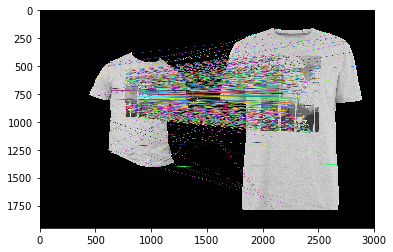

using SURF with lowe_ratio 0.75 there are 578 good matches


In [9]:
msg1 = 'using %s with lowe_ratio %.2f' % ("SURF", lowe_ratio)
msg2 = 'there are %d good matches' % (len(good))

#img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good, None, flags=2)

#font = cv2.FONT_HERSHEY_SIMPLEX
#cv2.putText(imMatches,msg1,(500, 1750), font, 2.5,(255,255,255),1,cv2.LINE_AA)
#cv2.putText(imMatches,msg2,(500, 1770), font, 2.5,(255,255,255),1,cv2.LINE_AA)
#fname = 'output_%s_%.2f.png' % (method, magic_number)

plt.imshow(imMatches),plt.show()

print (msg1 + ' '+ msg2)